# End-to-end Example

This notebook runs through a long-ish example of using the modules to analyze some survey data.

## Imports and setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
import json
import random
from typing import Any
from pprint import pprint
from IPython.display import Markdown, display, HTML
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
from survey_analysis.summarization import summarize_comments
from survey_analysis.theme_derivation import derive_themes
from survey_analysis.sentiment_analysis import (
    classify_sentiment, 
    sort_by_confidence,
    SentimentAnalysisResult
)
from survey_analysis.excerpt_extraction import extract_excerpts
from survey_analysis.multilabel_classification import multilabel_classify, default_tags_list

%matplotlib inline

In [2]:
# this makes it more robust to run async tasks inside an already async environment (jupyter notebooks)
import nest_asyncio
nest_asyncio.apply()

Make sure to either set `OPENAI_API_KEY` as an environment variable or put it in a .env file and use the following cell to load the env var. The format in the .env file is:
```
OPENAI_API_KEY=yourKeyGoesHere
```

In [3]:
load_dotenv(find_dotenv())

True

In [4]:
%load_ext autoreload
%autoreload 2

This is a convenience function to make seeing Pandas dataframe values easier, especially when there are long strings like the student comments we will be using.

In [5]:
def full_show(df):
    with pd.option_context('display.max_columns', None, 'display.max_rows', None, 'display.max_colwidth', None):
        display(df)

This is a convenience function for pretty-printing long student comments.

In [6]:
def print_wrap(text: str, width: int = 72) -> str:
    print(textwrap.fill(text, width=width))

## Load the example data

In [7]:
data_path = Path('../data/example_data')

Let's load up some fake data. 

All of these comments are synthetic to avoid sharing any sensitive or PII information, but they should work great for illustration purposes. There are 100 rows, with just a few null/nan values here and there for realism. In most surveys I've seen, there are quite a number of null/None/blank etc values, so the functions here are written to handle those.

In [8]:
example_survey = pd.read_csv(data_path / 'example_survey_data_synthetic.csv')
full_show(example_survey.head())

,best_parts,enhanced_learning,improve_course
0,I valued the practical clinical aspects related to immune-related disorders and their management.,The illustrative visuals and straightforward explanatory clips.,Consider reducing the duration of certain videos. A few appeared to be slightly prolonged.
1,The flexibility to learn at a self-determined speed,The opportunity to review the lecture content,"The pace of some lectures could be slowed down. At times, it's challenging to follow the lecturer's speech or decipher their handwriting."
2,The educational content was extremely enriching and stimulating! The section on oncology was the highlight.,the self-assessment activities.,Nothing specific comes to mind.
3,Professional growth within the medical sector,"The practical integration workshops were highly beneficial, they significantly contributed to a deeper comprehension of the theories and their implementation in a healthcare environment.",Incorporating a few advanced projects as optional tasks could benefit learners who wish to delve deeper into the subject matter. These projects wouldn't need to influence exam scores.
4,The highlights of the class included the practical demonstration clips that made the complex biological principles more understandable by connecting them to daily well-being and actions. This connection was incredibly beneficial as I navigated the course content.,"The aspect of the course that most facilitated my learning was the regular assessments provided at each segment, which helped confirm my grasp of the material presented. These checkpoints effectively guided me in the correct learning direction. It's evident that considerable effort was invested in designing these educational modules to enable students to gain a deep comprehension rather than just a superficial understanding of the subject matter.","Extend the duration of the concept videos for the more challenging topics, as they require a deeper dive to fully grasp the intricacies involved. Additionally, consider introducing an additional educator to the mix. The dynamic of having multiple voices in another subject area is quite engaging, and it would be beneficial to replicate that experience in this subject to prevent monotony from setting in with just one instructor."


## Plan

We're going to analyze to some example survey questions. The main overall goals are to show how one might explore the following questions:

1. What did students say about the course? (themes, summarization)
2. How did they feel about the course? (sentiment analysis)
3. What did they say about some aspect of interest? (extraction)
4. How did they feel about that aspect (focused sentiment analysis)
5. How many comments were there about different aspects? (multilabel classification)

If you're interested in this sort of thing, have a look at the paper called [A Large Language Model Approach to Educational Survey Feedback Analysis](https://arxiv.org/pdf/2309.17447.pdf). 

For the survey we'll be analyzing, there were three survey questions of interest. We'll define the questions themselves in variables for use later. We'll use these as metadata when passing along comments to the LLM routines. This is potentially important context for an LLM...after all, the survey comment "The flexibility to learn at a self-determined speed" may have different significance if the question was "What were the best parts of the course?" versus "What could be improved about the course?".

In [9]:
best_parts_question = "What were the best parts of the course?"
enhanced_learning_question = "What parts of the course enhanced your learning the most?"
improve_course_question = "What could be improved about the course?"

## 1. What did students say about the course?

When confronted with survey results, this is the high-level (vibes) step of getting a feel for what the major pieces of feedback were. Each question has its own context, so we'll analyze the results from each question separately. We'll look at a bottom-up approach versus a top-down approach.

### Theme derivation (bottom-up approach)

Here we'll come in without preconceived notions or categories and let the model derive the themes (from the bottom up, based on the comments). We'll also look at summarization as an alternative. Let's find the themes (common feedback expressed by multiple students), first from the "What were the best parts of the course?" survey question and then from the "What could be improved about the course?" question. The derive_themes function runs three passes by default, shuffling the order of the comments, given that the output for any single LLM run seems to depend on the order of the comments. For each pass, the model merges and distills the themes with the themes from the prior passes. 

In [10]:
best_parts_comments = example_survey['best_parts'].tolist() 
best_parts_themes = await derive_themes(comments=best_parts_comments, 
                                        question=best_parts_question, 
                                        shuffle_passes=3) # this defaults to 3 passes but just making it explicit here

pass 1
title: Practical Applications
description: Students appreciated the practical application segments, which helped deepen their understanding of complex concepts by relating them to real-world scenarios.

title: Visual and Multimedia Content
description: The use of visual aids, instructional videos, and multimedia resources was highly valued for making complex topics more understandable and engaging.

title: Interactive and Hands-On Learning
description: Interactive modules and hands-on activities were particularly beneficial for students, enhancing their learning experience through active participation.

title: Comprehensive and Structured Content
description: Students appreciated the well-organized and structured content, which facilitated a clear understanding of complex topics and principles.

title: Flexibility and Self-Paced Learning
description: The flexibility to learn at one's own pace was highly valued, especially for those balancing other commitments.

title: Quizzes an

Let's see the titles of the themes derived.

In [12]:
for theme in best_parts_themes.updated_themes:
    print(theme.theme_title)

Practical Applications
Visual and Multimedia Content
Interactive and Hands-On Learning
Comprehensive and Structured Content
Flexibility and Self-Paced Learning
Quizzes and Assessments
Expert and Engaging Instructors
Additional Resources
Fundamental Principles


Now let's take a look at the model's reasoning in combining themes along the way, across the different passes, and then get more detail on the final themes.

In [13]:
print('Reasoning:')
print_wrap(best_parts_themes.reasoning)
print('\nFinal Themes:\n')
for theme in best_parts_themes.updated_themes:
    print(f'Title: {theme.theme_title}')
    print_wrap(f'Description: {theme.description}')
    print('\n')

Reasoning:
1. 'Practical Applications' and 'Practical Application' are clearly
about the same topic, focusing on the practical application of course
material.  2. 'Visual and Multimedia Content' (both instances) are
identical in title and description, so they should be merged.  3.
'Interactive and Hands-On Learning' and 'Interactive and Hands-On
Activities' are about interactive and hands-on learning methods, so they
should be merged.  4. 'Comprehensive and Structured Content' and 'Clear
and Structured Content' both emphasize the structured and clear
presentation of course material, so they should be merged.  5. 'Quizzes
and Assessments' and 'Assessments and Quizzes' are about the same topic,
focusing on quizzes and assessments, so they should be merged.  6.
'Flexibility and Self-Paced Learning' (both instances) are identical in
title and description, so they should be merged.  7. 'Expert
Instruction' and 'Engaging and Inspiring Instructors' both focus on the
quality and engagement of 

Let's do the same thing for the feedback comments for the survey question "What could be improved about the course?".

In [14]:
improve_course_comments = example_survey['improve_course'].tolist() 
improve_course_themes = await derive_themes(comments=improve_course_comments, 
                                            question=improve_course_question)

pass 1
title: Video Duration and Pace
description: Students expressed concerns about the duration and pace of the videos, suggesting adjustments to improve comprehension.

title: Advanced and Optional Projects
description: Students suggested incorporating advanced projects as optional tasks for those who wish to delve deeper into the subject matter.

title: Additional Visual Aids
description: Students recommended the inclusion of more visual aids to enhance understanding of the material.

title: Alignment of Content and Assessments
description: Students noted a need for better alignment between course content and assessments to ensure consistency and relevance.

title: Extended Course Duration
description: Students felt that the course duration was too short and suggested extending it to allow for a deeper exploration of the subject matter.

title: Practical and Clinical Applications
description: Students expressed a desire for more practical and clinical applications, including case s

First let's take a look at the titles of the themes derived.

In [15]:
for theme in improve_course_themes.updated_themes:
    print(theme.theme_title)

Video Duration and Pace
Advanced and Practical Projects
Enhanced Multimedia and Visual Aids
Alignment of Content and Assessments
Extended Course Duration and Depth
Practical and Clinical Applications
Interactive and Engaging Activities
Comprehensive and Updated Content
Clarity and Simplicity of Materials
Additional Study Resources
Consistent Language in Presentations


...and some more detail about the themes and the reasoning for combining themes.

In [16]:
print('Reasoning:')
print_wrap(improve_course_themes.reasoning)
print('\nFinal Themes:\n')
for theme in improve_course_themes.updated_themes:
    print(f'Title: {theme.theme_title}')
    print_wrap(f'Description: {theme.description}')
    print('\n')

Reasoning:
1. 'Extended Course Duration and Depth' and 'Extended Course Duration'
both address the need for a longer course duration to explore topics in
more depth. These should be merged. 2. 'Practical and Clinical
Applications' and 'More Practical and Clinical Applications' both focus
on the need for more practical and clinical applications. These should
be merged. 3. 'Additional Study Resources' and 'Additional Learning
Resources' both suggest the need for more study materials and resources.
These should be merged. 4. 'Alignment of Content and Assessments' and
'Improved Alignment and Clarity' both discuss the need for better
alignment and clarity between course content and assessments. These
should be merged. 5. 'Additional Visual Aids' and 'Enhanced Multimedia
and Visual Aids' both recommend more visual aids and multimedia
elements. These should be merged. 6. 'Interactive and Engaging
Activities' and 'More Interactive Content' both suggest incorporating
more interactive elements. 

### Summarization

Here's an alternate approach that summarizes a group of comments to come up with themes. We'll just do this for the "What could be improved about the course?" question. The output is less structured than for theme derivation, so it would be a bit harder to pull out the themes automatically into a spreadsheet (or as a basis for classification...what we'll do after this).

In [17]:
improve_course_summarization_result = await summarize_comments(comments=improve_course_comments, 
                                                               question=improve_course_question)

display(Markdown((improve_course_summarization_result.summary)))

The student feedback highlights several key areas for improvement in the course: 
1. **Video Content**: Mixed feedback on video duration, with some students suggesting shorter videos for simpler topics and longer videos for complex topics. There were also requests for clearer video lectures and more comprehensive notes or outlines accompanying the videos.
2. **Pacing and Clarity**: Some students found the pace of lectures too fast and suggested slowing down, especially for complex topics. There were also comments about the need for clearer handwriting and more straightforward phrasing of questions.
3. **Additional Content**: Requests for more advanced projects, case studies, practical exercises, and content on specific topics like cancer treatments, immunotherapy, and next-generation sequencing. Some students also suggested including more real-life applications and patient scenarios.
4. **Interactive Elements**: Suggestions to incorporate more interactive elements such as simulations, live tutoring, and engaging activities. There were also requests for more practical clinical demonstrations and mock tests.
5. **Assessment Alignment**: Feedback on aligning quizzes and assessments more closely with the course content, and making the questions more straightforward. Some students also suggested increasing the number of tries for assessments and including a mid-term assessment.
6. **Resources and Accessibility**: Requests for additional study resources, downloadable content, and ongoing access to course materials. Some students also suggested providing subtitles in other languages and making subtitles selectable for copying.
7. **Instructor Dynamics**: A few students suggested introducing additional educators to provide a dynamic learning experience and ensure consistency in language and presentation style across different lectures.
8. **Visual Aids and Multimedia**: Suggestions to incorporate more visual aids, multimedia presentations, and comprehensive descriptions to enhance understanding. There were also requests for more detailed diagrams and visual content in the learning materials.

When I ran this for the example, the model happened to format the output in Markdown, so that's the way I'm displaying it above. The themes are not exactly the same as what we came up with from theme derivation, but that's to be expected. The content of them, if you read the descriptions, is pretty similar to what we saw from theme derivation.

One thing the derived themes leave hanging is how many students actually remarked on each theme. We'll address that in the last part of this notebook using multilabel classification.

## 2. How did students feel about the course?

### Sentiment analysis

Figuring out students' sentiment can give an overall sense of the comments and help prioritize which ones might be actionable or let you see what aspects provoked the most positive or negative comments. There are other ways of getting people's overall sentiment, for example net promoter score or Likert scales, but there is additional information from sentiment. For example, it is not uncommon to see a person give a good net promoter score but provide some critical feedback in certain survey question columns.


Here we classify the comments that were in response to the question about the best parts of the course.

In [18]:
best_parts_sentiment_results = await classify_sentiment(comments=best_parts_comments, question=best_parts_question)

processing 100 inputs in batches of 100
sleeping for 30 seconds between batches
starting 0 to 100
completed 0 to 100
elapsed time: 4.164031028747559


We can first take a look at some verbose output, but the main thing to pay attention to is the sentiment and the fine_grained_sentiment_category. The sentiment for each comment is 'positive', 'negative', or 'neutral', and the fine grained sentiment further subdivides neutral into 'neutral-positive', 'neutral', or 'neutral-negative'. We'll look at the sentiment of the comments in a more visual way shortly, but here is detailed output of every tenth comment in order from most positive to most negative.

In [19]:
best_parts_pairs = sort_by_confidence(best_parts_comments, best_parts_sentiment_results)
for comment, result in best_parts_pairs[::10]:
    print(f'Student comment: "{comment}"')
    pprint(json.loads(result.model_dump_json(exclude={'logprobs'})))
    print('\n')

Student comment: "The flexibility to learn at a self-determined speed"
{'classification_confidence': {'difference': 'Infinity',
                               'next_token': None,
                               'top_token': 'positive'},
 'fine_grained_sentiment_category': 'positive',
 'reasoning': 'The comment highlights a positive aspect of the course, '
              "specifically the flexibility to learn at one's own pace. This "
              'indicates satisfaction and appreciation for this feature.',
 'sentiment': 'positive',
 'sentiment_logprobs': [{'linear_prob': 100.0,
                         'logprob': 0.0,
                         'token': 'positive'},
                        {'linear_prob': 0.0,
                         'logprob': -23.25,
                         'token': 'posit'},
                        {'linear_prob': 0.0,
                         'logprob': -24.875,
                         'token': 'Positive'}]}


Student comment: "the engaging online activities"
{'cla

We will also run sentiment analysis over the survey feedback about how the course can be improved before visualizing both to compare.

In [20]:
improve_course_sentiment_results = await classify_sentiment(comments=improve_course_comments, question=improve_course_question)

processing 100 inputs in batches of 100
sleeping for 30 seconds between batches
starting 0 to 100
completed 0 to 100
elapsed time: 3.689965009689331


...and check out the ranking of the comments along with the detailed reasoning of the logic behind why each comment was classified that way. Here we'll just look at a sampling of a smaller number of comments.

In [21]:
improve_course_pairs = sort_by_confidence(improve_course_comments, improve_course_sentiment_results)
for comment, result in improve_course_pairs[::20]:
    print(f'Student comment: "{comment}"')
    pprint(json.loads(result.model_dump_json(exclude={'logprobs'})))
    print('\n')

Student comment: "nothing, the course is already excellent"
{'classification_confidence': {'difference': 16.37499980638735,
                               'next_token': 'negative',
                               'top_token': 'positive'},
 'fine_grained_sentiment_category': 'positive',
 'reasoning': 'The comment indicates that the student believes the course is '
              'already excellent and does not need any improvements. This '
              'suggests a positive sentiment towards the course.',
 'sentiment': 'positive',
 'sentiment_logprobs': [{'linear_prob': 100.0,
                         'logprob': -1.9361265e-07,
                         'token': 'positive'},
                        {'linear_prob': 0.0,
                         'logprob': -16.375,
                         'token': 'negative'},
                        {'linear_prob': 0.0,
                         'logprob': -17.75,
                         'token': 'posit'}]}


Student comment: "Extend the duration! The cour

### Displaying the sentiment results

Just for visualization sake, we create a display helper function for pretty output ranked by sentiment from most positive to most negative (from blue to red). This color theme is best viewed on a dark background (dark theme).

In [24]:
color_map = {'positive': 'MediumSlateBlue', 
            'neutral-positive': 'LightSkyBlue',
            'neutral': 'LightGray',
            'neutral-negative': 'LightSalmon',
            'negative': 'Red'}

def colorized_html_output(pairs: tuple[str, SentimentAnalysisResult]) -> Any:
    html_output = ""
    for comment, result in pairs:
        color = color_map[result.fine_grained_sentiment_category]
        html_output += f'<span style="color:{color}; font-size:1.2em">"{comment}"</span><br>'

    return HTML(html_output)

def reference_colors():
    """This is kind of like a legend for the colorized_html_output"""
    html_output = ""
    for category, color in color_map.items():
        html_output += f'<span style="color:{color}; font-size:1.2em">{category}</span><br>'

    return HTML(html_output)

In [25]:
display(reference_colors())

Let's look at the best parts comments visualized. We'll choose a random subset to make the output less lengthy, but it should give us a good idea of the proportion of comments falling into each category. (I'm setting a random seed so you see the same random subset when you run this on your own, but feel free to comment that out.) If you want to see the full output, comment out the first four lines and uncomment the last line.

In [26]:
random.seed(1)
random_indices = random.sample(range(len(best_parts_pairs)), 50)
random_indices.sort()
display(colorized_html_output(best_parts_pairs[i] for i in random_indices))
# display(colorized_html_output(best_parts_pairs))

Interesting...overwhelmingly positive (as we would expect, based on the question), but you can see that the non-positive ones are more ambiguous. Now let's compare with a random subset of the comments from the question about improving the course.

In [27]:
random.seed(1)
improve_random_indices = random.sample(range(len(improve_course_pairs)), 50)
improve_random_indices.sort()
display(colorized_html_output(improve_course_pairs[i] for i in improve_random_indices))

That makes sense! You would expect asking for suggestions for improvement to elicit some comments that could be more negative, and you can see, based on the colors, how the sentiment has shifted relative to the best parts comments.

Just a note that for sure using an LLM is not the only way to do sentiment analysis, but some of the specialized models out there that I tried didn't match up against human intuition/ratings all that well, perhaps based on the fact that tweets (or similar training data) are fairly different than course reviews.

## 3. What did students say about some aspect of interest? (extraction)

In this case, let's say we want to know what suggestions for improvement students had about the lectures and videos. We can define that as our goal focus and pass that along.

In [28]:
goal_focus = "lectures and videos"
lec_vid_excerpts = await extract_excerpts(comments=improve_course_comments,
                                          question=improve_course_question,
                                          goal_focus=goal_focus)

# we'll just look at the first 10 comments and their excerpts
for comment, excerpts in list(zip(improve_course_comments, lec_vid_excerpts))[:10]:
    print_wrap(f'Student comment: "{comment}"')
    pprint(excerpts.model_dump())
    print('\n')

processing 100 inputs in batches of 100
sleeping for 30 seconds between batches
starting 0 to 100
completed 0 to 100
elapsed time: 5.00259804725647
Student comment: "Consider reducing the duration of certain videos. A
few appeared to be slightly prolonged."
{'excerpts': ['Consider reducing the duration of certain videos. A few '
              'appeared to be slightly prolonged.']}


Student comment: "The pace of some lectures could be slowed down. At
times, it's challenging to follow the lecturer's speech or decipher
their handwriting."
{'excerpts': ["The pace of some lectures could be slowed down. At times, it's "
              "challenging to follow the lecturer's speech or decipher their "
              'handwriting.']}


Student comment: "Nothing specific comes to mind."
{'excerpts': []}


Student comment: "Incorporating a few advanced projects as optional
tasks could benefit learners who wish to delve deeper into the subject
matter. These projects wouldn't need to influence exam s

That seemed to work well. You can see from looking at the output of how it did extraction on the first 10 of the comments that it honed in on the parts about the lectures and vides. As an example, the comment

> "Extend the duration of the concept videos for the more
challenging topics, as they require a deeper dive to fully grasp the
intricacies involved. Additionally, consider introducing an additional
educator to the mix. The dynamic of having multiple voices in another
subject area is quite engaging, and it would be beneficial to replicate
that experience in this subject to prevent monotony from setting in with
just one instructor."

had the excerpt:

> "Extend the duration of the concept videos for the more challenging topics, as they require a deeper dive to fully grasp the intricacies involved."

## 4. How did they feel about that aspect (focused sentiment analysis)

Now we can analyze the sentiment of the excerpts for a more nuanced picture. Remember, these are in response to the "how can the course be improved?" question, so we would expect a bit more of a negative skew, given that that is the way the question is oriented.

In [29]:
# first get all the excerpts in a single flattened list
from itertools import chain
lec_vid_excerpts_flat = list(chain.from_iterable(result.excerpts for result in lec_vid_excerpts if result.excerpts))
lec_video_sentiment_results = await classify_sentiment(comments=lec_vid_excerpts_flat, 
                                                       question="How could the lectures and videos be improved?")

processing 22 inputs in batches of 100
sleeping for 30 seconds between batches
starting 0 to 100
completed 0 to 100
elapsed time: 2.2172789573669434


...and check out the ranking of the comments along with the detailed reasoning of the logic behind why each comment was classified that way. Here we'll just look at a small sampling of the comments.

In [31]:
lec_vid_sentiment_pairs = sort_by_confidence(lec_vid_excerpts_flat, lec_video_sentiment_results)
for excerpt, result in lec_vid_sentiment_pairs[::10]:
    print(f'Excerpt: "{excerpt}"')
    pprint(json.loads(result.model_dump_json(exclude={'logprobs'})))
    print('\n')

Excerpt: "Incorporating a live tutoring option during video playback could be beneficial."
{'classification_confidence': {'difference': 4.624999922000001,
                               'next_token': 'positive',
                               'top_token': 'neutral'},
 'fine_grained_sentiment_category': 'neutral-positive',
 'reasoning': 'The comment suggests an improvement by incorporating a live '
              'tutoring option during video playback. The tone is constructive '
              'and implies a positive outlook towards enhancing the learning '
              'experience, but it does not express dissatisfaction or negative '
              'feelings about the current state.',
 'sentiment': 'neutral',
 'sentiment_logprobs': [{'linear_prob': 99.03,
                         'logprob': -0.009756678,
                         'token': 'neutral'},
                        {'linear_prob': 0.97,
                         'logprob': -4.6347566,
                         'token': 'positive'}

In [32]:
display(reference_colors())

In [33]:
display(colorized_html_output(lec_vid_sentiment_pairs))

Not bad...the overall sentiment distribution is pretty similar to the sentiment distribution of the "how can the coures be improved?" comments we looked at previously. The excerpts are sometimes brief and judging sentiment in a fine-grained way is not so easy. But you can imagine that if you had one thousand such excerpts, having some judgment of sentiment might help you prioritize.

## 5. How many comments were there about different aspects? (multilabel classification)

Here we get into quantification of what comments were about. It would be helpful to have that kind of quantification, particularly if we're trying to use the data to help with decisions about whether it's worth it to devote resources (including time and energy) to make changes to the course based on the feedback.

There are (at least) a couple of ways we can go about quantifying. One is to continue the bottom-up approach and use the themes derived from the comments themselves to classify the comments. The second way is what I would label top-down, which essentially means using a pre-defined set of tags or labels. These are based on major areas of interest that are applicable to many types of courses. Using a pre-defined set of tags also allows better comparison across cohorts as you act on feedback and make iterative changes to a course.

### Mult-label classification (bottom-up tags)

Let's use the theme derivation results to quantify how many comments were about each theme. The themes weren't intended as category labels, but we can effectively use them that way and classify the comments using multilabel classification.  

First we'll turn the themes derived from the 'best parts' comments into the format needed (a list of dictionaries). We could also load tags from a file, as we'll see when we do the top-down approach.

In [34]:
best_parts_tags = [{'topic': theme.theme_title, 'description': theme.description}
                  for theme in best_parts_themes.updated_themes]

best_parts_tags

[{'topic': 'Practical Applications',
  'description': 'Students appreciated the practical application segments and real-world clinical scenarios, which helped deepen their understanding of complex concepts by relating them to real-world scenarios.'},
 {'topic': 'Visual and Multimedia Content',
  'description': 'The use of visual aids, instructional videos, animations, and multimedia resources was highly valued for making complex topics more understandable and engaging.'},
 {'topic': 'Interactive and Hands-On Learning',
  'description': 'Interactive modules and hands-on activities were particularly beneficial for students, enhancing their learning experience through active participation.'},
 {'topic': 'Comprehensive and Structured Content',
  'description': 'Students appreciated the well-organized, clear, and structured content, which facilitated a clear understanding of complex topics and principles.'},
 {'topic': 'Flexibility and Self-Paced Learning',
  'description': "The flexibility

Next we do the classification on the same comments that we derived the themes from.

In [35]:
mlc_best_parts_bottomup = await multilabel_classify(comments=best_parts_comments, 
                                                    tags_list=best_parts_tags)

processing 100 inputs in batches of 100
sleeping for 30 seconds between batches
starting 0 to 100
completed 0 to 100
elapsed time: 5.481243133544922


Let's look at the output classifications, along with the model's reasoning for each. Any categories that are selected have 1 as the value. We'll just look at the first five comments for brevity.

In [37]:
for comment, classification in list(zip(best_parts_comments, mlc_best_parts_bottomup))[:5]:
    pprint(comment)
    pprint(json.loads(classification.model_dump_json()))

('I valued the practical clinical aspects related to immune-related disorders '
 'and their management.')
{'categories': {'Additional_Resources': 0,
                'Comprehensive_and_Structured_Content': 0,
                'Expert_and_Engaging_Instructors': 0,
                'Flexibility_and_Self-Paced_Learning': 0,
                'Fundamental_Principles': 0,
                'Interactive_and_Hands-On_Learning': 0,
                'Practical_Applications': 1,
                'Quizzes_and_Assessments': 0,
                'Visual_and_Multimedia_Content': 0},
 'reasoning': 'The comment specifically mentions the practical clinical '
              'aspects related to immune-related disorders and their '
              'management, which falls under the category of Practical '
              'Applications.'}
'The flexibility to learn at a self-determined speed'
{'categories': {'Additional_Resources': 0,
                'Comprehensive_and_Structured_Content': 0,
                'Expert_and_En

The above is not easy to look at efficiently. Let's turn the results into a dataframe...something you would typically do to download the results.

In [39]:
# make a dataframe with comments in one column and the pivoted tag categories as the other columns
results_df = pd.DataFrame({'comment': best_parts_comments})
values_df = pd.json_normalize([classification.categories.model_dump() for classification in mlc_best_parts_bottomup]).map(lambda x: x.value)
reasoning_df = pd.DataFrame({"reasoning": [classification.reasoning for classification in mlc_best_parts_bottomup]})

bp_results_df = pd.concat([results_df, reasoning_df, values_df], axis=1)

full_show(bp_results_df.head())

,comment,reasoning,Practical_Applications,Visual_and_Multimedia_Content,Interactive_and_Hands-On_Learning,Comprehensive_and_Structured_Content,Flexibility_and_Self-Paced_Learning,Quizzes_and_Assessments,Expert_and_Engaging_Instructors,Additional_Resources,Fundamental_Principles
0,I valued the practical clinical aspects related to immune-related disorders and their management.,"The comment specifically mentions the practical clinical aspects related to immune-related disorders and their management, which falls under the category of Practical Applications.",1,0,0,0,0,0,0,0,0
1,The flexibility to learn at a self-determined speed,"The comment highlights the ability to learn at one's own pace, which directly relates to the flexibility and self-paced learning category.",0,0,0,0,1,0,0,0,0
2,The educational content was extremely enriching and stimulating! The section on oncology was the highlight.,"The comment praises the educational content as enriching and stimulating, which suggests it is comprehensive and well-structured. The mention of a specific section (oncology) being a highlight indicates that the content is detailed and possibly covers fundamental principles.",0,0,0,1,0,0,0,0,1
3,Professional growth within the medical sector,"The comment mentions 'professional growth within the medical sector,' which does not directly align with any of the provided categories. It is more about career development rather than specific aspects of the course content or delivery.",0,0,0,0,0,0,0,0,0
4,The highlights of the class included the practical demonstration clips that made the complex biological principles more understandable by connecting them to daily well-being and actions. This connection was incredibly beneficial as I navigated the course content.,The comment mentions practical demonstration clips that helped in understanding complex biological principles by connecting them to daily well-being and actions. This indicates the use of practical applications and visual and multimedia content.,1,1,0,0,0,0,0,0,0


Let's turn this into a plot to get an overall sense. (This requires you have matplotlib and seaborn installed. Instead of this, feel free to download the dataframe and plot it in your favorite program).

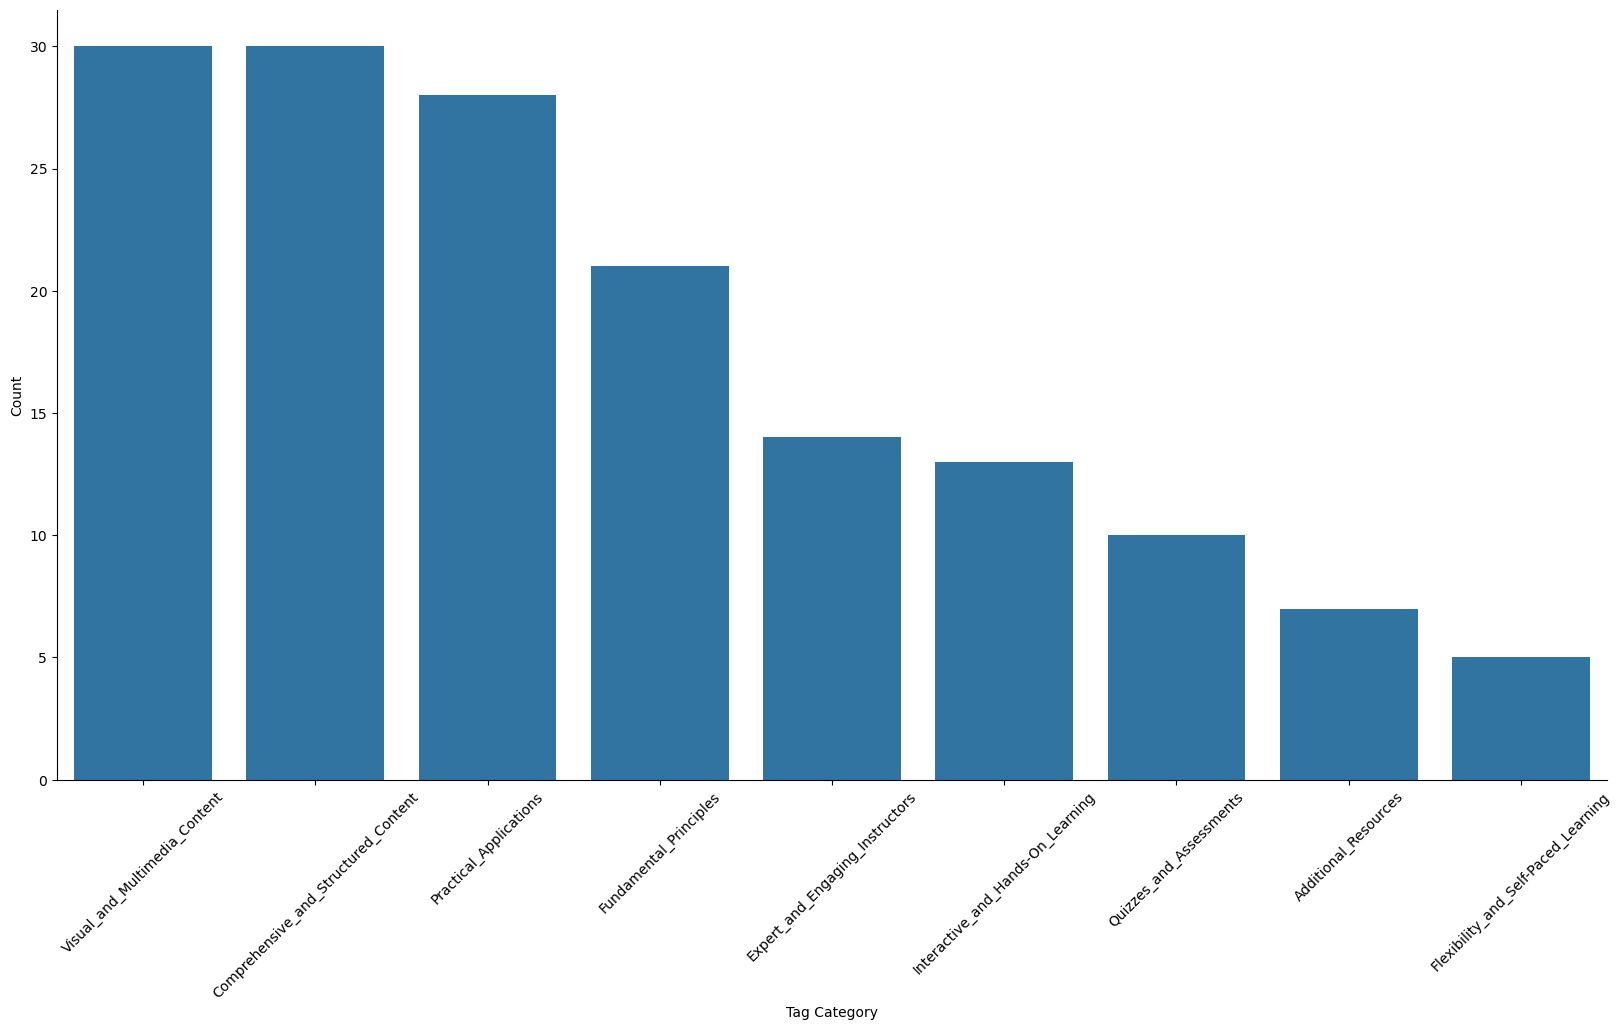

In [42]:
plt.figure(figsize=(20, 10))
data = bp_results_df.iloc[:, 2:].sum().sort_values(ascending=False).reset_index()
data.columns = ['index', 'Count']
ax = sns.barplot(data=data, x='index', y='Count')
ax.tick_params(axis='x', rotation=45)
plt.ylabel("Count")
plt.xlabel("Tag Category")
sns.despine(top=True, right=True)
plt.show()

### Multi-label classification (top-down approach)

Here we come in with a set of labels that we've developed and stress-tested that should apply to many types of courses and classify comments based on those categories.

First let's take a look at the predefined tags.

In [43]:
default_tags_list

[{'topic': 'course logistics and fit',
  'description': 'course delivery (policy, support), cost, difficulty, time commitment, grading, credit, schedule, user fit, access, background (e.g. prereqs and appropriateness of course level).'},
 {'topic': 'curriculum',
  'description': 'course content, curriculum, specific topics, course structure.  This focuses on the content and the pedagogical structure of the content, including flow and organization.  This also includes applied material such as clinical cases and case studies. Includes references to pre-recorded discussions between experts or between a doctor and a patient. Includes specific suggestions for additional courses or content.'},
 {'topic': 'teaching modality',
  'description': 'video, visual, interactive, animation, step-by-step, deep dive, background builder (the format rather than the content/topic).'},
 {'topic': 'teaching',
  'description': 'instructors, quality of teaching and explanations'},
 {'topic': 'assessment', 'des

Next we do the classification and show a small number of comments from the output.

In [45]:
mlc_best_parts_topdown = await multilabel_classify(comments=best_parts_comments) 

for comment, classification in list(zip(best_parts_comments, mlc_best_parts_topdown))[:5]:
    pprint(comment)
    pprint(json.loads(classification.model_dump_json()))
    print('\n')

processing 100 inputs in batches of 100
sleeping for 30 seconds between batches
starting 0 to 100
completed 0 to 100
elapsed time: 3.0846049785614014
('I valued the practical clinical aspects related to immune-related disorders '
 'and their management.')
{'categories': {'assessment': 0,
                'course_logistics_and_fit': 0,
                'curriculum': 1,
                'other': 0,
                'peer_and_teacher_interaction': 0,
                'resources': 0,
                'teaching': 0,
                'teaching_modality': 0},
 'reasoning': 'The comment highlights the practical clinical aspects related '
              'to immune-related disorders and their management, which '
              'pertains to the curriculum of the course.'}


'The flexibility to learn at a self-determined speed'
{'categories': {'assessment': 0,
                'course_logistics_and_fit': 0,
                'curriculum': 0,
                'other': 0,
                'peer_and_teacher_intera

Let's turn the results into a dataframe.

In [47]:
# make a dataframe with comments in one column and the pivoted tag categories as the other columns
td_results_df = pd.DataFrame({'comment': best_parts_comments})
td_values_df = pd.json_normalize([classification.categories.model_dump() for classification in mlc_best_parts_topdown]).map(lambda x: x.value)
td_reasoning_df = pd.DataFrame({"reasoning": [classification.reasoning for classification in mlc_best_parts_topdown]})

td_results_df = pd.concat([td_results_df, td_reasoning_df, td_values_df], axis=1)

full_show(td_results_df.head())

,comment,reasoning,course_logistics_and_fit,curriculum,teaching_modality,teaching,assessment,resources,peer_and_teacher_interaction,other
0,I valued the practical clinical aspects related to immune-related disorders and their management.,"The comment highlights the practical clinical aspects related to immune-related disorders and their management, which pertains to the curriculum of the course.",0,1,0,0,0,0,0,0
1,The flexibility to learn at a self-determined speed,"The comment mentions the flexibility to learn at a self-determined speed, which relates to the teaching modality of the course.",0,0,1,0,0,0,0,0
2,The educational content was extremely enriching and stimulating! The section on oncology was the highlight.,"The comment praises the educational content, specifically mentioning the section on oncology as a highlight. This feedback is related to the curriculum of the course.",0,1,0,0,0,0,0,0
3,Professional growth within the medical sector,"The comment is about professional growth within the medical sector, which does not directly relate to any of the provided categories. It is more of a general statement.",0,0,0,0,0,0,0,1
4,The highlights of the class included the practical demonstration clips that made the complex biological principles more understandable by connecting them to daily well-being and actions. This connection was incredibly beneficial as I navigated the course content.,The comment praises the practical demonstration clips for making complex biological principles more understandable and connecting them to daily well-being and actions. This indicates that the teaching modality (use of practical demonstration clips) and curriculum (course content) were effective.,0,1,1,0,0,0,0,0


Now let's plot this one. (Again, this requires you have matplotlib and seaborn installed. Instead of this, feel free to download the dataframe and plot it in your favorite program).

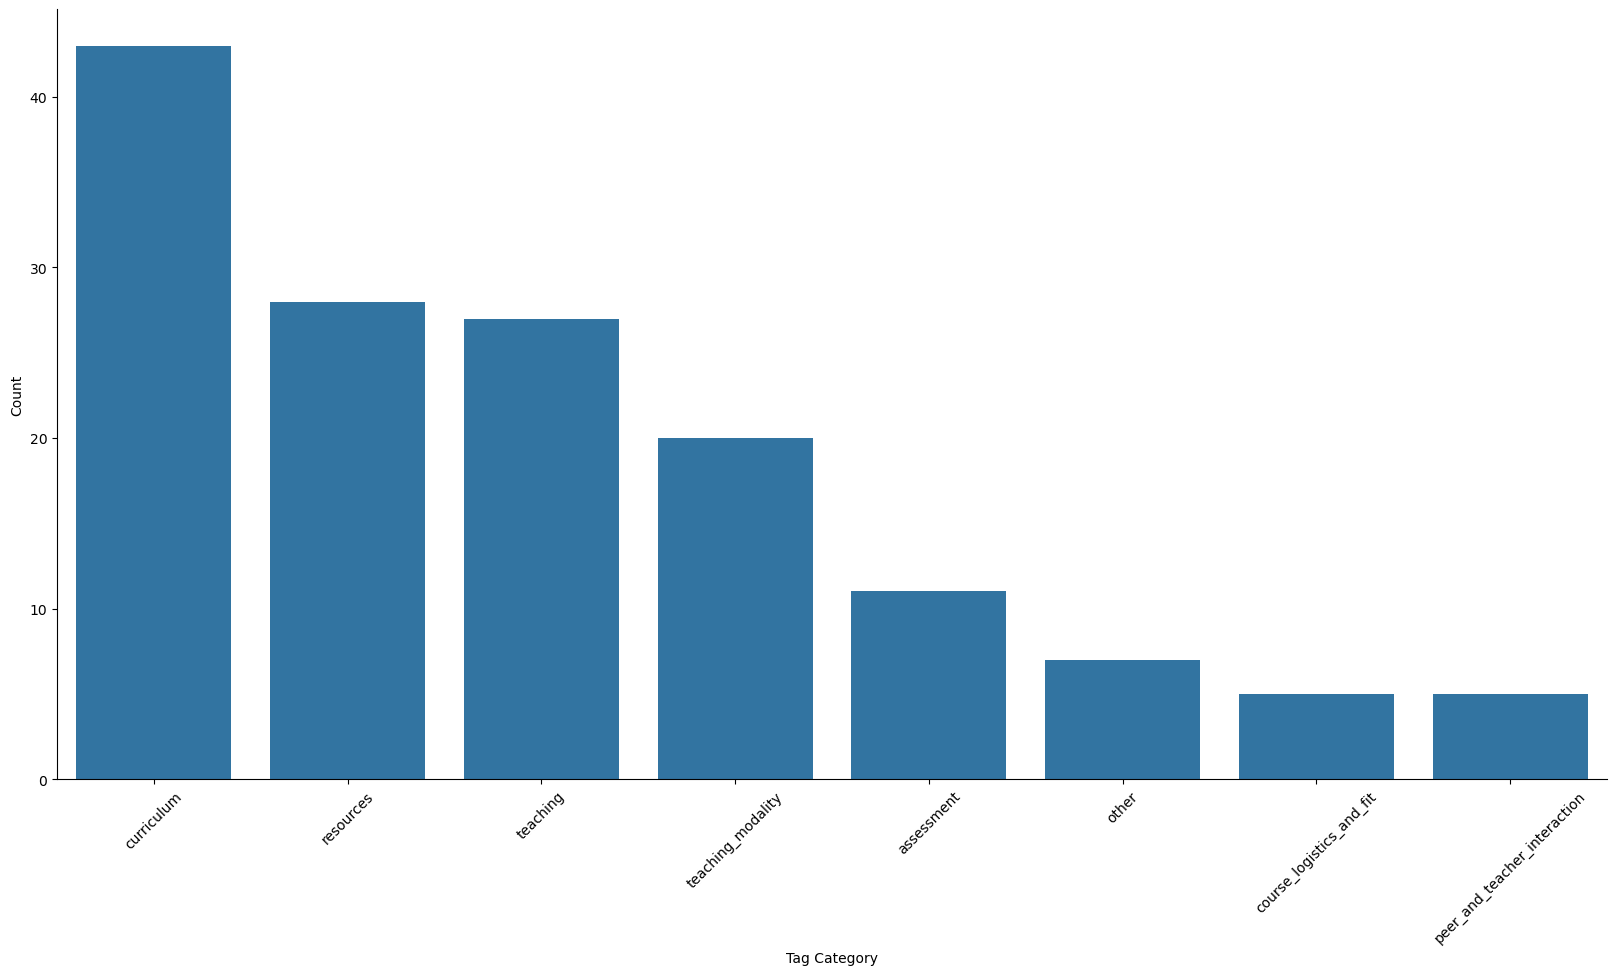

In [50]:
plt.figure(figsize=(20, 10))
data = td_results_df.iloc[:, 2:].sum().sort_values(ascending=False).reset_index()
data.columns = ['index', 'Count']
ax = sns.barplot(data=data, x='index', y='Count')
ax.tick_params(axis='x', rotation=45)

plt.ylabel("Count")
plt.xlabel("Tag Category")
sns.despine(top=True, right=True)
plt.show()

Just out of curiosity, let's see what was said in the course_logistics_and_fit category.

In [51]:
for comment in td_results_df.loc[lambda x: x['course_logistics_and_fit'] == 1, 'comment'].to_list():
    print_wrap(f'"{comment}"') # print helper defined under imports and setup
    print('\n')

"Organization, progression, scholarly debates, and narratives of actual
patients"


"The course was structured clearly. Found every lecture to be engaging."


"The most advantageous aspects of the course included its digital format
and the adaptability regarding the timing for completing various
segments. This flexibility was particularly beneficial for me as a full-
time employee, as it enabled consistent participation in the course that
would have been challenging otherwise."


"The course was informative, though it required more time than
anticipated for those without prior background. Balancing a full-time
job with the additional hours needed for the course was quite demanding,
particularly towards the conclusion when the workload intensified.
Nevertheless, the knowledge gained was substantial, and the delivery by
the educators was of high quality. However, I noticed that certain
examination questions seemed to extend beyond the material covered in
the course. For instance, the cla

It's interesting to be able to zero in on comments like these. It's one thing when you have a small number of comments, but with hundreds or even thousands of feedback comments, having the ability to drill down into results is incredibly helpful.